In [50]:
!pip install medmnist

In [51]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

# Device setup
# Check for CUDA
if torch.cuda.is_available():
	device = torch.device("cuda")
	print("Using CUDA (GPU)")
	
# Check for MPS (Apple Silicon Macs)
elif torch.backends.mps.is_available():
	device = torch.device("mps")
	print("Using MPS (macOS)")
	
else:
	device = torch.device("cpu")
	print("Using CPU")

# Example usage: Move model and tensors to the selected device

import medmnist
from medmnist import INFO, Evaluator

Using CUDA (GPU)


In [52]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# First work on a 2D dataset with size 28x28

In [54]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## Read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [56]:
# preprocessing
data_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [57]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: C:\Users\Jonah\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CR

In [58]:
# visualization

train_dataset.montage(length=1)

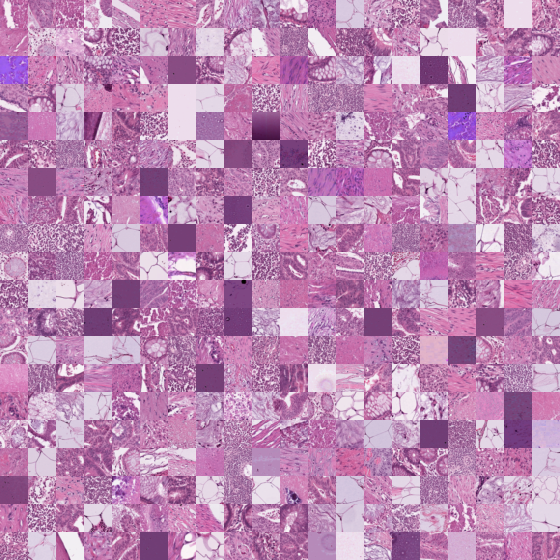

In [59]:
# montage

train_dataset.montage(length=20)

## Simple model for illustration, object function and optimizer that we use to classify

In [61]:
# define a simple CNN model

class Net(nn.Module):
	def __init__(self, in_channels, num_classes):
		super(Net, self).__init__()

		self.layer1 = nn.Sequential(
			nn.Conv2d(in_channels, 16, kernel_size=3),
			nn.BatchNorm2d(16),
			nn.ReLU())

		self.layer2 = nn.Sequential(
			nn.Conv2d(16, 16, kernel_size=3),
			nn.BatchNorm2d(16),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2))

		self.layer3 = nn.Sequential(
			nn.Conv2d(16, 64, kernel_size=3),
			nn.BatchNorm2d(64),
			nn.ReLU())
		
		self.layer4 = nn.Sequential(
			nn.Conv2d(64, 64, kernel_size=3),
			nn.BatchNorm2d(64),
			nn.ReLU())

		self.layer5 = nn.Sequential(
			nn.Conv2d(64, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2))

		self.fc = nn.Sequential(
			nn.Linear(64 * 4 * 4, 128),
			nn.ReLU(),
			nn.Linear(128, 128),
			nn.ReLU(),
			nn.Linear(128, num_classes))

	def forward(self, x):
		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		x = self.layer4(x)
		x = self.layer5(x)
		x = x.view(x.size(0), -1)
		x = self.fc(x)
		return x

model = Net(in_channels=n_channels, num_classes=n_classes).to(device)
	
# define loss function and optimizer
if task == "multi-label, binary-class":
	criterion = nn.BCEWithLogitsLoss()
else:
	criterion = nn.CrossEntropyLoss()
	
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Train and Evaluate

In [63]:
# train

for epoch in range(NUM_EPOCHS):
	train_correct = 0
	train_total = 0
	test_correct = 0
	test_total = 0
	
	model.train()
	for inputs, targets in tqdm(train_loader):
		# forward + backward + optimize
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = model(inputs)
		
		if task == 'multi-label, binary-class':
			targets = targets.to(torch.float32)
			loss = criterion(outputs, targets)
		else:
			targets = targets.squeeze().long()
			loss = criterion(outputs, targets)
		
		loss.backward()
		optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [00:25<00:00, 27.30it/s]


In [64]:
# evaluation
def test(split):
	model.eval()
	y_true = torch.tensor([], device=device)
	y_score = torch.tensor([], device=device)
	
	data_loader = train_loader_at_eval if split == 'train' else test_loader

	with torch.no_grad():
		for inputs, targets in data_loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)

			if task == 'multi-label, binary-class':
				targets = targets.to(torch.float32)
				outputs = outputs.softmax(dim=-1)
			else:
				targets = targets.squeeze().long()
				outputs = outputs.softmax(dim=-1)
				targets = targets.float().resize_(len(targets), 1)

			y_true = torch.cat((y_true, targets), 0)
			y_score = torch.cat((y_score, outputs), 0)

		y_true = y_true.cpu().numpy()
		y_score = y_score.cpu().detach().numpy()
		
		evaluator = Evaluator(data_flag, split)
		metrics = evaluator.evaluate(y_score)
	
		print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

		
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.987  acc:0.857
test  auc: 0.945  acc:0.733


## LIME Implementation (224*224 Images)

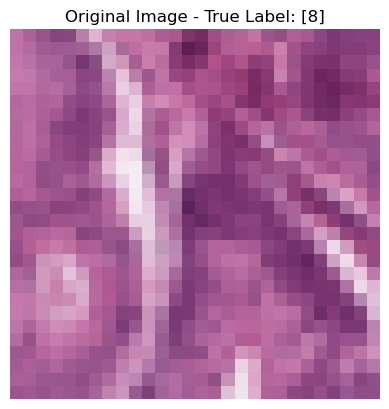

  0%|          | 0/1000 [00:00<?, ?it/s]

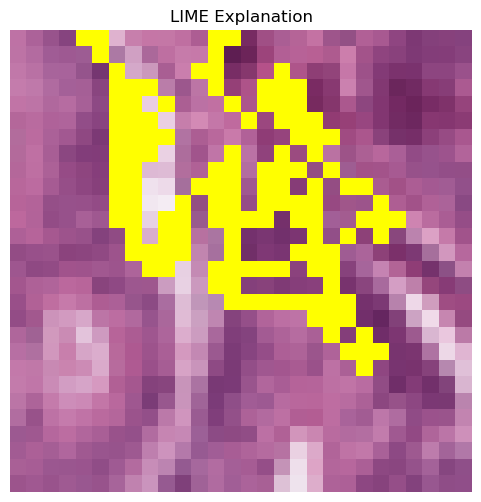

In [66]:
#Import required modules for LIME
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import felzenszwalb

#Get a sample image and reverse the preprocessing
# Extract image from test_dataset (already normalized and tensor format)
tensor_img, label = test_dataset[0]  # index can be changed

#Unnormalize and convert to HWC format in [0, 255]
unnormalized_img = tensor_img * 0.5 + 0.5   # From [-1,1] to [0,1]
np_img = unnormalized_img.numpy().transpose(1, 2, 0)  # CHW -> HWC
np_img = (np_img * 255).astype(np.uint8)  # Convert to uint8 [0,255]

#Visualize the raw image
plt.imshow(np_img)
plt.title(f"Original Image - True Label: {label}")
plt.axis('off')
plt.show()

#Define prediction function for LIME
def predict_fn(images):
    # images: list of np arrays in HWC format [0,255]
    model.eval()
    # Convert to torch tensors in CHW and normalize to [-1,1]
    images = np.array([img.transpose(2, 0, 1) for img in images]) / 255.0
    images = (images - 0.5) / 0.5
    tensor_batch = torch.tensor(images, dtype=torch.float32).to(device)
    outputs = model(tensor_batch)
    probs = torch.softmax(outputs, dim=1)
    return probs.detach().cpu().numpy()

#Create LimeImageExplainer instance and explain
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image=np_img,              # Input image in HWC format
    classifier_fn=predict_fn,  # Prediction function
    top_labels=5,
    hide_color=0,
    num_samples=1000,           # Number of perturbations
    segmentation_fn=lambda x: felzenszwalb(x, scale=20, sigma=0.5, min_size=5)
)

#Visualize the explanation for the top class
from skimage.color import label2rgb

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

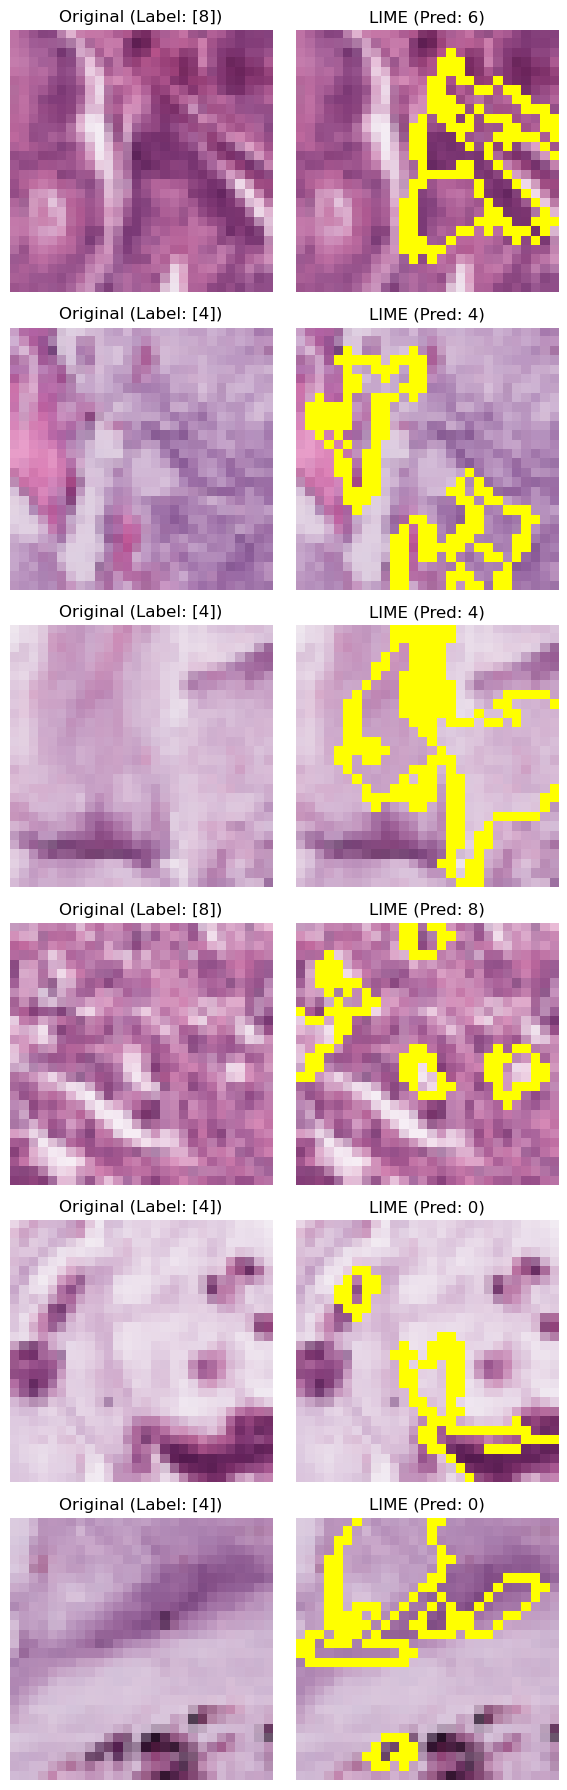

In [79]:
#Group Comparison
num_images = 6 #number of images

#LIME explainer
explainer = lime_image.LimeImageExplainer()

#Set up matplotlib figure
fig, axes = plt.subplots(num_images, 2, figsize=(6, num_images * 3))

for idx in range(num_images):
    #Get raw image (HWC) from normalized dataset
    tensor_img, label = test_dataset[idx]
    unnormalized_img = tensor_img * 0.5 + 0.5
    np_img = (unnormalized_img.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    #LIME explanation
    explanation = explainer.explain_instance(
        image=np_img,
        classifier_fn=predict_fn,
        top_labels=1,
        num_samples=1000,
        segmentation_fn=lambda x: felzenszwalb(x, scale=20, sigma=0.5, min_size=5)
    )

    #Get top class mask
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    #Plot original image
    axes[idx, 0].imshow(np_img)
    axes[idx, 0].set_title(f"Original (Label: {label})")
    axes[idx, 0].axis('off')

    #Plot LIME explanation
    axes[idx, 1].imshow(mark_boundaries(temp / 255.0, mask))
    axes[idx, 1].set_title(f"LIME (Pred: {explanation.top_labels[0]})")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

# 2D dataset with size 224x224

In [19]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
# train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [20]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 224 (pathmnist_224)
    Number of datapoints: 89996
    Root location: C:\Users\Jonah\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split N

In [21]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([3, 224, 224]) (1,)


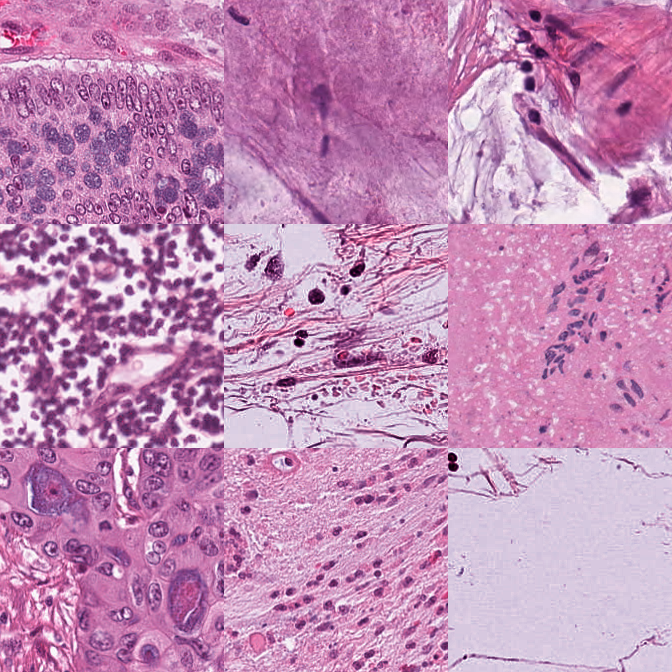

In [22]:
train_dataset.montage(length=3)

## Train and Evaluate on 224*224 dataset 

In [24]:
from torchvision.models import resnet18

model = resnet18(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
	
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [25]:
# train

for epoch in range(NUM_EPOCHS):
	train_correct = 0
	train_total = 0
	test_correct = 0
	test_total = 0
	
	model.train()
	for inputs, targets in tqdm(train_loader):
		# forward + backward + optimize 
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = model(inputs)
		
		if task == 'multi-label, binary-class':
			targets = targets.to(torch.float32)
			loss = criterion(outputs, targets)
		else:
			targets = targets.squeeze().long()
			loss = criterion(outputs, targets)
		
		loss.backward()
		optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████| 704/704 [01:48<00:00,  6.50it/s]


In [26]:
# evaluation

def test(split):
	model.eval()
	y_true = torch.tensor([], device=device)
	y_score = torch.tensor([], device=device)
	
	data_loader = train_loader_at_eval if split == 'train' else test_loader

	with torch.no_grad():
		for inputs, targets in data_loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)

			if task == 'multi-label, binary-class':
				targets = targets.to(torch.float32)
				outputs = outputs.softmax(dim=-1)
			else:
				targets = targets.squeeze().long()
				outputs = outputs.softmax(dim=-1)
				targets = targets.float().resize_(len(targets), 1)

			y_true = torch.cat((y_true, targets), 0)
			y_score = torch.cat((y_score, outputs), 0)

		y_true = y_true.cpu().numpy()
		y_score = y_score.cpu().detach().numpy()
		
		evaluator = Evaluator(data_flag, split)
		metrics = evaluator.evaluate(y_score)
	
		print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

		
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.998  acc:0.937
test  auc: 0.967  acc:0.799


## LIME Implementation (224*224 Images, ResNet Model)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

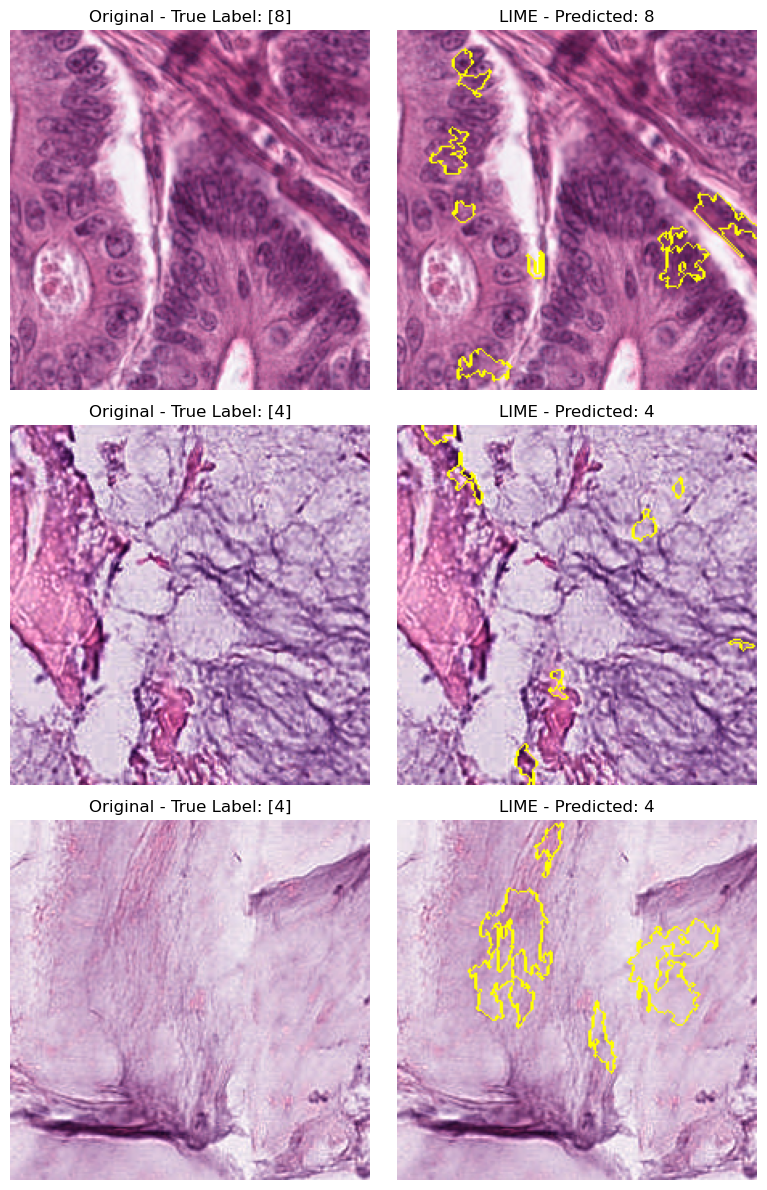

In [28]:
from lime import lime_image
from skimage.segmentation import mark_boundaries, felzenszwalb
import matplotlib.pyplot as plt
import numpy as np

#Prediction function
def predict_fn(images):
    model.eval()
    # Convert to tensor, normalize to [-1, 1] like original transform
    tensor = torch.tensor(
        np.array([img.transpose(2, 0, 1) for img in images]) / 255.0,
        dtype=torch.float32
    )
    tensor = (tensor - 0.5) / 0.5
    tensor = tensor.to(device)
    with torch.no_grad():
        outputs = model(tensor)
        probs = torch.softmax(outputs, dim=1)
    return probs.cpu().numpy()

#Visualize multiple LIME explanations
def show_lime_explanations(num_images=3):
    explainer = lime_image.LimeImageExplainer()
    fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 4))

    for idx in range(num_images):
        tensor_img, label = test_dataset[idx]
        unnormalized_img = tensor_img * 0.5 + 0.5
        np_img = (unnormalized_img.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

        # LIME explanation
        explanation = explainer.explain_instance(
            image=np_img,
            classifier_fn=predict_fn,
            top_labels=1,
            num_samples=1000,
            segmentation_fn=lambda x: felzenszwalb(x, scale=30, sigma=0.5, min_size=20)
        )

        temp, mask = explanation.get_image_and_mask(
            label=explanation.top_labels[0],
            positive_only=True,
            num_features=8,
            hide_rest=False
        )

        # Plot original and explanation side-by-side
        axes[idx, 0].imshow(np_img)
        axes[idx, 0].set_title(f"Original - True Label: {label}")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(mark_boundaries(temp / 255.0, mask))
        axes[idx, 1].set_title(f"LIME - Predicted: {explanation.top_labels[0]}")
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

#Visualization
show_lime_explanations(num_images=3)